## 5.2 Masked relationship

What we learned from the divorce example

- multiple predictor variables are useful for knocking out spurious association
- measure the direct influences of multiple factors on an outcome

### The Dataset

* Information about milk across primate species like brain size and body mass
* 29 row and 8 variables
* the variable we consider are:
    * e kcal.per.g (kilocalories of energy per gram of milk)
    * mass (average female body mass, in kilograms)
    * neocortex.perc (percent of total brain mass that is neocortex mass)

A popular hypothesis has it that primates with larger brains produce more energetic
milk, so that brains can grow quickly

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

from IPython.core.display import Image

In [2]:
df_milk = pd.read_csv("milk.csv")

# Display the structure of the dataset
print(df_milk.info())

# Optionally display a preview of the dataset
df_milk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      29 non-null     int64  
 1   clade           29 non-null     object 
 2   species         29 non-null     object 
 3   kcal.per.g      29 non-null     float64
 4   perc.fat        29 non-null     float64
 5   perc.protein    29 non-null     float64
 6   perc.lactose    29 non-null     float64
 7   mass            29 non-null     float64
 8   neocortex.perc  17 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.2+ KB
None


,Unnamed: 0,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,1,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,2,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,3,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,4,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,5,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### The question

The question
here is to what extent energy content of milk, measured here by kilocalories, is related to the
percent of the brain mass that is neocortex.

First we *standardize* the three variables

In [4]:
def standardize(series):
    return (series - series.mean()) / series.std()

# Apply standardization
df_milk["K"] = standardize(df_milk["kcal.per.g"])
df_milk["N"] = standardize(df_milk["neocortex.perc"])
df_milk["M"] = standardize(np.log(df_milk["mass"]))

The first model to consider is the simple bivariate regression between kilocalories and
neocortex percent.

Check NA values

In [7]:
df_milk["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

Remove rows with NaN values, we reduce the dataset to 17 rows

In [8]:
df_milk_clean = df_milk.dropna(subset=["K", "N", "M"])

### Fist model with priors with normalization sigma of 1 for a and bN

In [45]:
with pm.Model() as model_5_5_draft:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    bN = pm.Normal("bN", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)
    
    # Linear model
    mu = a + bN * df_milk_clean["N"]
    
    # Likelihood
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk_clean["K"])
    
    # Sample posterior
    trace_5_5_draft = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [2]:
# Step 1: Extract the prior samples
with model_5_5_draft:  # Assuming `model` is the previously defined PyMC model
    prior_predictive = pm.sample_prior_predictive(samples=1000)

# Step 2: Define xseq
xseq = np.array([-2, 2])

# Step 3: Compute mu using the prior
# This assumes `a` and `bN` are the sampled priors
a_samples = prior_predictive.prior["a"]
bN_samples = prior_predictive.prior["bN"]

# Compute mu for each x in xseq
mu = np.array([a_samples + bN_samples * x for x in xseq])

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


NameError: name 'model_5_5_draft' is not defined

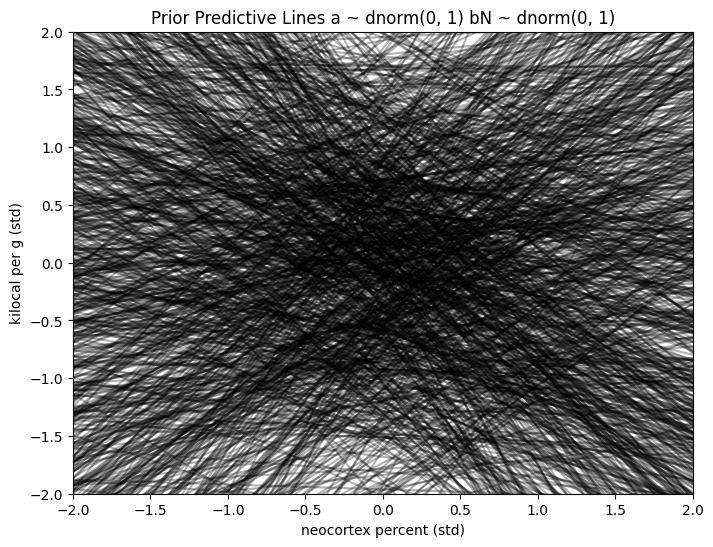

In [47]:
# Assuming xseq and mu are already defined
# xseq = np.array([-2, 2])  # Range for x values
# mu = np.array([...])      # Predicted values for each prior sample

plt.figure(figsize=(8, 6))

# Set up the plot with appropriate limits
plt.xlim(xseq[0], xseq[1])
plt.ylim(xseq[0], xseq[1])

# Plot 50 sampled lines with transparency
for i in range(1):
    plt.plot(xseq, mu[:, i], color="black", alpha=0.3)

# Add labels and show the plot
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.title("Prior Predictive Lines a ~ dnorm(0, 1) bN ~ dnorm(0, 1)")
plt.show()


The lines are crazy and we must change the sigma that we are closer to zero

### Fist model with priors with normalization sigma of 0.2 for a and 0.5 for bN

In [48]:
# Assuming dcc is a DataFrame that contains 'K' and 'N'

with pm.Model() as model_5_5:
    # Priors for the parameters
    a = pm.Normal("a", mu=0, sigma=0.2)
    bN = pm.Normal("bN", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # Linear model for mu
    mu = a + bN * df_milk_clean["N"]
    
    # Likelihood function
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk_clean["K"])
    
    # Sample from the posterior
    trace_5_5 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [49]:
# Step 1: Extract the prior samples
with model_5_5:  # Assuming `model` is the previously defined PyMC model
    prior_predictive = pm.sample_prior_predictive(samples=1000)

# Step 2: Define xseq
xseq = np.array([-2, 2])

# Step 3: Compute mu using the prior
# This assumes `a` and `bN` are the sampled priors
a_samples = prior_predictive.prior["a"]
bN_samples = prior_predictive.prior["bN"]

# Compute mu for each x in xseq
mu = np.array([a_samples + bN_samples * x for x in xseq])

Sampling: [K, a, bN, sigma]


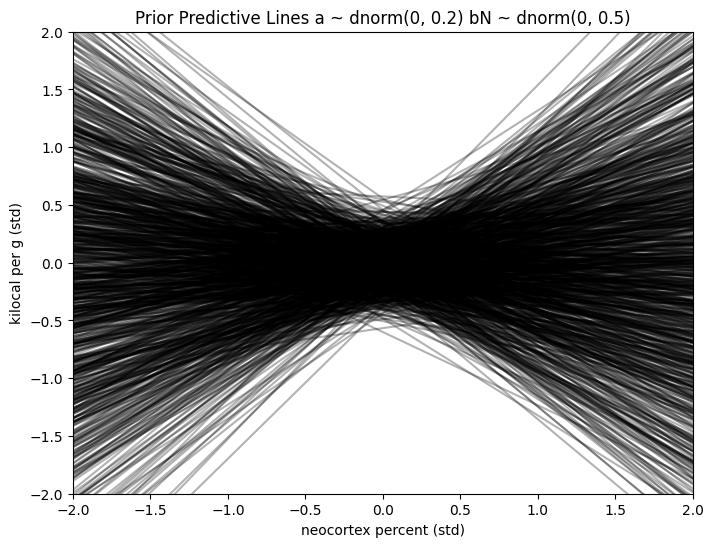

In [50]:
# Assuming xseq and mu are already defined
# xseq = np.array([-2, 2])  # Range for x values
# mu = np.array([...])      # Predicted values for each prior sample

plt.figure(figsize=(8, 6))

# Set up the plot with appropriate limits
plt.xlim(xseq[0], xseq[1])
plt.ylim(xseq[0], xseq[1])

# Plot 50 sampled lines with transparency
for i in range(1):
    plt.plot(xseq, mu[:, i], color="black", alpha=0.3)

# Add labels and show the plot
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.title("Prior Predictive Lines a ~ dnorm(0, 0.2) bN ~ dnorm(0, 0.5)")
plt.show()


These are still very vague priors, but at least the lines stay within the high probability region of the observable data.

In [51]:
import arviz as az

# Assuming 'trace' is the result from pm.sample()
summary = az.summary(trace_5_5, hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.036,0.161,-0.291,0.339,0.002,0.002,4314.0,3189.0,1.0
bN,0.130,0.244,-0.345,0.617,0.003,0.004,5068.0,2959.0,1.0
sigma,1.114,0.206,0.761,1.520,0.003,0.002,4781.0,2637.0,1.0


om this summary, you can possibly see that this is neither a strong nor very precise association. The standard deviation is almost twice the posterior mean.

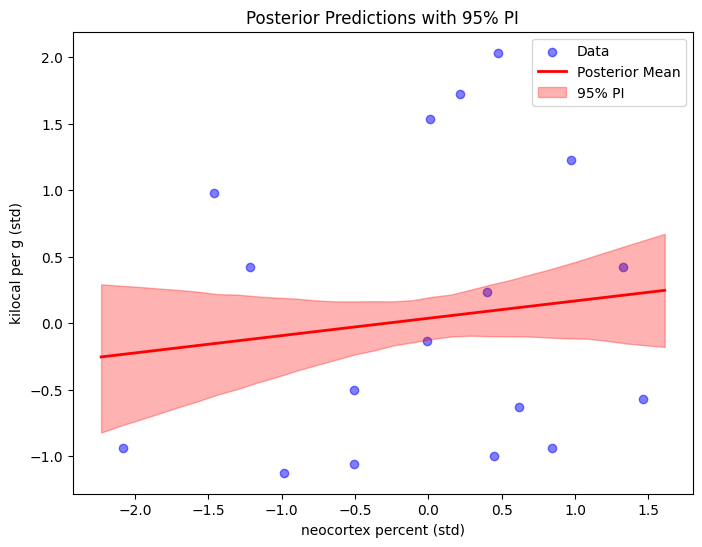

In [52]:
# Assuming 'dcc' is a pandas DataFrame and 'trace' contains the posterior samples
# 'trace' is the result of pm.sample()

# Step 1: Generate xseq (sequence of N values)
xseq = np.linspace(min(df_milk_clean["N"]) - 0.15, max(df_milk_clean["N"]) + 0.15, 30)

# Step 2: Get the posterior samples for 'a' and 'bN'
a_samples = trace_5_5.posterior["a"].values  # Shape: (4, 1000)  # 4 chains, 1000 samples
bN_samples = trace_5_5.posterior["bN"].values  # Shape: (4, 1000)  # 4 chains, 1000 samples

# Step 3: Reshape the posterior samples for broadcasting
a_samples = a_samples.mean(axis=0)  # Average across chains, result shape: (1000,)
bN_samples = bN_samples.mean(axis=0)  # Average across chains, result shape: (1000,)

# Step 4: Calculate mu for each xseq value using the posterior samples
mu = a_samples[:, None] + bN_samples[:, None] * xseq  # Shape: (1000, 30)

# Step 5: Calculate mu_mean and mu_PI (posterior mean and 95% credible interval)
mu_mean = np.mean(mu, axis=0)  # Mean over the posterior samples, shape: (30,)
mu_PI = np.percentile(mu, [2.5, 97.5], axis=0)  # 95% posterior interval

# Step 6: Plot the data and posterior predictions
plt.figure(figsize=(8, 6))

# Scatter plot of observed data (K vs. N)
plt.scatter(df_milk_clean["N"], df_milk_clean["K"], label="Data", color="blue", alpha=0.5)

# Plot the posterior mean of mu
plt.plot(xseq, mu_mean, label="Posterior Mean", color="red", linewidth=2)

# Shade the 95% credible interval (Posterior Interval)
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="red", alpha=0.3, label="95% PI")

# Labels and title
plt.xlabel("neocortex percent (std)")
plt.ylabel("kilocal per g (std)")
plt.title("Posterior Predictions with 95% PI")

# Show the plot
plt.legend()
plt.show()


The posterior mean line is weakly positive, but it is highly imprecise. A lot of mildly positive and negative slopes are plausible, given this model and these data.


### Model with female body mass (mass) as predictor

In [60]:
# Assuming dcc is a DataFrame that contains 'K' and 'N'

with pm.Model() as model_5_6:
    # Priors for the parameters
    a = pm.Normal("a", mu=0, sigma=0.2)
    bN = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # Linear model for mu
    mu = a + bN * df_milk_clean["M"]
    
    # Likelihood function
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk_clean["K"])
    
    # Sample from the posterior
    trace_5_6 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [61]:
# Assuming 'trace' is the result from pm.sample()
summary = az.summary(trace_5_6, hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.040,0.155,-0.269,0.341,0.002,0.002,5052.0,3083.0,1.0
bM,-0.273,0.211,-0.683,0.135,0.003,0.003,4980.0,2713.0,1.0
sigma,1.061,0.196,0.733,1.469,0.003,0.002,4154.0,2777.0,1.0


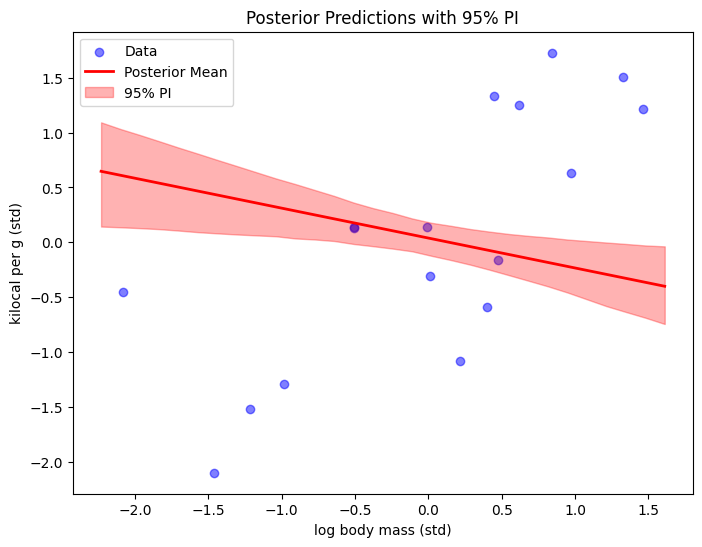

In [62]:
# Assuming 'dcc' is a pandas DataFrame and 'trace' contains the posterior samples
# 'trace' is the result of pm.sample()

# Step 1: Generate xseq (sequence of N values)
xseq = np.linspace(min(df_milk_clean["M"]) - 0.15, max(df_milk_clean["M"]) + 0.15, 30)

# Step 2: Get the posterior samples for 'a' and 'bN'
a_samples = trace_5_6.posterior["a"].values  # Shape: (4, 1000)  # 4 chains, 1000 samples
bN_samples = trace_5_6.posterior["bM"].values  # Shape: (4, 1000)  # 4 chains, 1000 samples

# Step 3: Reshape the posterior samples for broadcasting
a_samples = a_samples.mean(axis=0)  # Average across chains, result shape: (1000,)
bN_samples = bN_samples.mean(axis=0)  # Average across chains, result shape: (1000,)

# Step 4: Calculate mu for each xseq value using the posterior samples
mu = a_samples[:, None] + bN_samples[:, None] * xseq  # Shape: (1000, 30)

# Step 5: Calculate mu_mean and mu_PI (posterior mean and 95% credible interval)
mu_mean = np.mean(mu, axis=0)  # Mean over the posterior samples, shape: (30,)
mu_PI = np.percentile(mu, [2.5, 97.5], axis=0)  # 95% posterior interval

# Step 6: Plot the data and posterior predictions
plt.figure(figsize=(8, 6))

# Scatter plot of observed data (K vs. N)
plt.scatter(df_milk_clean["N"], df_milk_clean["M"], label="Data", color="blue", alpha=0.5)

# Plot the posterior mean of mu
plt.plot(xseq, mu_mean, label="Posterior Mean", color="red", linewidth=2)

# Shade the 95% credible interval (Posterior Interval)
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="red", alpha=0.3, label="95% PI")

# Labels and title
plt.xlabel("log body mass (std)")
plt.ylabel("kilocal per g (std)")
plt.title("Posterior Predictions with 95% PI")

# Show the plot
plt.legend()
plt.show()


Log-mass is negatively associated with kilocalories. This association does seem stronger than that of neocortex percent, although in the opposite direction.

### Model with female body mass (mass) and neocortex as predictor

In [56]:
# Assuming dcc is a pandas DataFrame containing 'K', 'N', and 'M'

with pm.Model() as model_5_7:
    # Priors for the parameters
    a = pm.Normal("a", mu=0, sigma=0.2)
    bN = pm.Normal("bN", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    
    # Linear model for mu
    mu = a + bN * df_milk_clean["N"] + bM * df_milk_clean["M"]
    
    # Likelihood function
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=df_milk_clean["K"])
    
    # Sample from the posterior
    trace_5_7 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, bM, sigma]


C:\git\sagemaker_job_tracking\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [58]:
# Assuming 'trace' is the result from pm.sample()
summary = az.summary(trace_5_7, hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.056,0.143,-0.216,0.347,0.003,0.002,3197.0,2919.0,1.0
bN,0.601,0.272,0.076,1.127,0.005,0.004,2749.0,2475.0,1.0
bM,-0.639,0.245,-1.094,-0.144,0.005,0.003,2766.0,2725.0,1.0
sigma,0.863,0.173,0.548,1.201,0.004,0.003,2485.0,2391.0,1.0


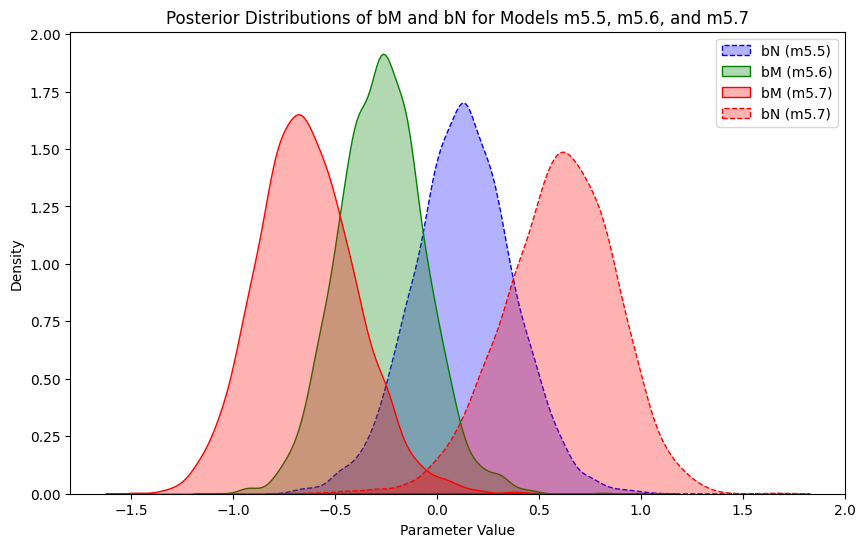

In [65]:
# Assuming that `trace_m5_5`, `trace_m5_6`, and `trace_m5_7` are the traces from the respective models

# Extract posterior samples for the parameters of interest
bN_m5_5 = trace_5_5.posterior["bN"].values.flatten()

bM_m5_6 = trace_5_6.posterior["bM"].values.flatten()

bM_m5_7 = trace_5_7.posterior["bM"].values.flatten()
bN_m5_7 = trace_5_7.posterior["bN"].values.flatten()

# Combine the results into a DataFrame for easier plotting
import pandas as pd

df = pd.DataFrame({
    "bN_m5_5": bN_m5_5,
    "bM_m5_6": bM_m5_6,
    "bM_m5_7": bM_m5_7,
    "bN_m5_7": bN_m5_7
})

# Set up a seaborn plot for visual comparison of the posterior distributions
plt.figure(figsize=(10, 6))

# Plot the distributions for bM and bN across all models
sns.kdeplot(df["bN_m5_5"], label="bN (m5.5)", color="blue", linestyle="--", fill=True, alpha=0.3)

sns.kdeplot(df["bM_m5_6"], label="bM (m5.6)", color="green", fill=True, alpha=0.3)

sns.kdeplot(df["bM_m5_7"], label="bM (m5.7)", color="red", fill=True, alpha=0.3)
sns.kdeplot(df["bN_m5_7"], label="bN (m5.7)", color="red", linestyle="--", fill=True, alpha=0.3)

# Add labels and title
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.title("Posterior Distributions of bM and bN for Models m5.5, m5.6, and m5.7")

# Show the plot with a legend
plt.legend()
plt.show()


The posterior means for neocortex percent and log-mass have both moved away from zero. his is a context in which there are two variables correlated with the outcome, but one is positively correlated with it and the other is negatively correlated with it. In addition, both of the explanatory variables are positively correlated with
one another

### DAG

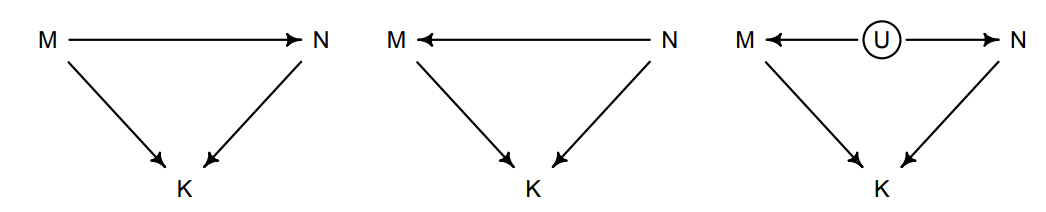

In [68]:
Image(filename="./images/dag_5_2.png")

* Beginning on the left, the first possibility is that body mass (M) influences neocortex percent (N). Both then influence kilocalories in milk (K).
* Second, in the middle, neocortex could instead influence body mass. The two variables still end up correlated in the sample.
* Finally, on the right, there could be an unobserved variable U that influences both M and N, producing a correlation between them

Which of these graphs is right? We can’t tell from the data alone, because these graphs imply the same set of conditional independencies. In this case, there are no conditional
independencies—each DAG above implies that all pairs of variables are associated, regardless of what we condition on.

**A set of DAGs with the same conditional independencies is known as a Markov equivalence set.**

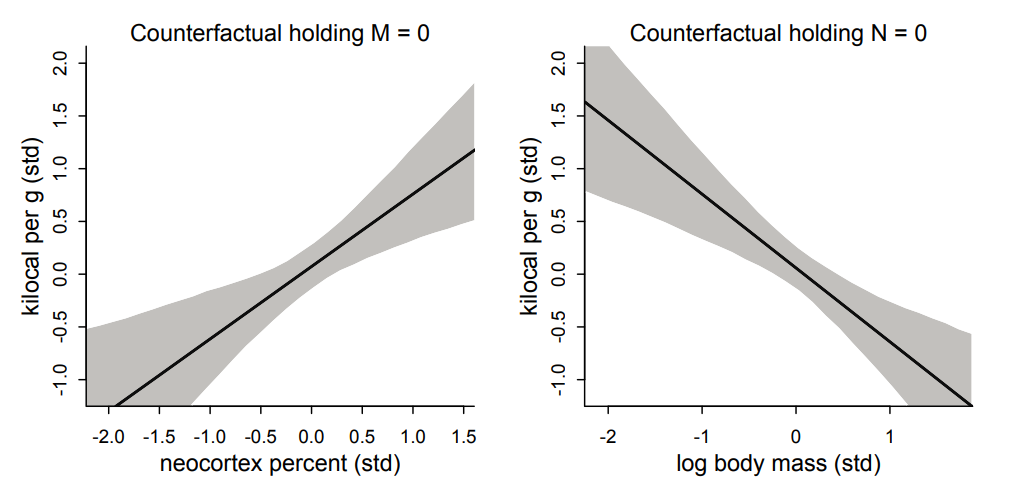

In [82]:
Image(filename="./images/counterfactual_5_2.png")

- These counterfactual plots do help us see how the model views the association between each predictor and the outcome
- Suppose the third DAG above is the right one. Then imagine manipulating M and N, breaking the influence of U on each

## Overthinking

- In the primate milk example, it may be that the positive association between large body size and neocortex percent arises from a tradeoff between lifespan and learning. Large animals tend to live a long time
- Both large body size and large neocortex then influence milk composition, but in different directions, for different reasons. This story implies that the DAG with an arrow from M to N, the first one, is the right one